In [1]:
import os

import networkx as nx
import numpy as np
import pandas as pd

from graspy.utils import import_graph, pass_to_ranks
from graspy.embed import OmnibusEmbed, ClassicalMDS
from graspy.cluster import GaussianCluster

import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_dissimilarity(X, n_graphs, n_vertices):
    """
    Computes test statistics based on each pairs 

    Returns
    -------
    out : array-like, shape (n_graphs, n_graphs)
        A dissimilarity matrix based on Frobenous norms between pairs of
        graphs.
    """

    zhat = X.reshape(n_graphs, n_vertices, -1)

    out = np.zeros((n_graphs, n_graphs))
    for i in range(n_graphs):
        out[i] = np.linalg.norm(zhat - zhat[i], axis=(1, 2), ord='fro')

    return out

In [3]:
fmri_path = '../desikan_hnu1_fmri/'
fmris = os.listdir(fmri_path)

dmri_path = '../desikan_hnu1_dwi/'
dmris = os.listdir(dmri_path)

In [4]:
subjects = [s.split('_')[0] for s in dmris]
subjects_unique = sorted(list(set(subjects)))

subjects_corrected = []

for subject in subjects_unique:
    fmri_tmp = [f for f in fmris if subject in f]
    fmri_sessions = [f.split('_')[1] for f in fmris if subject in f]
    dmri_tmp = [f for f in dmris if subject in f]
    dmri_sessions = [f.split('_')[1] for f in dmris if subject in f]
    
    matched_sessions = []
    for session in fmri_sessions:
        if session in dmri_sessions:
            subjects_corrected.append(subject + '_' + session + '_')
            matched_sessions.append(session)

In [5]:
dmris_corrected = []
fmris_corrected = []

for subject in subjects_corrected:
    for i in dmris:
        if subject in i:
            dmris_corrected.append(i)
            
    for i in fmris:
        if subject in i:
            fmris_corrected.append(i)
            
dmris = dmris_corrected
fmris = fmris_corrected

len(fmris), len(dmris)

(274, 274)

In [6]:
for idx in range(len(fmris)):
    f = fmris[idx].split('_')
    d = dmris[idx].split('_')
    
    assert f[0] == d[0]
    assert f[1] == d[1]

In [21]:
tmp1 = []
tmp2 = []

for subject in subjects_corrected:
    tmp1 += [subject + 'fmri']
    tmp2 += [subject + 'dmri']
    
subject_scan_labels = tmp1 + tmp2

subject_labels = [f.split("_")[0] for f in subjects_corrected]

In [23]:
len(subject_labels)

274

In [25]:
fmri_graphs = [np.load(fmri_path + f) for f in fmris]
dmri_graphs = [np.load(dmri_path + f) for f in dmris]

fmri_graphs = [pass_to_ranks(f) for f in fmri_graphs]
dmri_graphs = [pass_to_ranks(f) for f in dmri_graphs]

#graphs = fmri_graphs[:10] + dwi_graphs[:10] + fmri_graphs[10:] + dwi_graphs[10:]
#graphs = fmri_graphs + dmri_graphs

len(fmri_graphs), len(dmri_graphs)

(274, 274)

## Multimodal, multigraph clustering

### Embedding the multimodal graphs all at once

Data summary
- subjects = 30
- total fmri scans = 274
- total dmri scans = 274
- total scans = 548

Desikan atlas
- num vertices = 70

## Concatenating results from fMRI and DWIs

First we embed graphs from DWIs and fMRIs separately. Then we concatenate the resulting estimated latent position vectors

In [26]:
K = 50
omni = OmnibusEmbed(k=K)
dmri_hat = omni.fit_transform(dmri_graphs)

omni = OmnibusEmbed(k=K)
fmri_hat = omni.fit_transform(fmri_graphs)

Z_hat = np.hstack([fmri_hat, dmri_hat])
Z_hat.shape

(19180, 100)

In [28]:
dissimilarity = get_dissimilarity(Z_hat, 274, K*2)

In [29]:
dissimilarity.shape

(274, 274)

### T-semipar shows block structure based on subjects

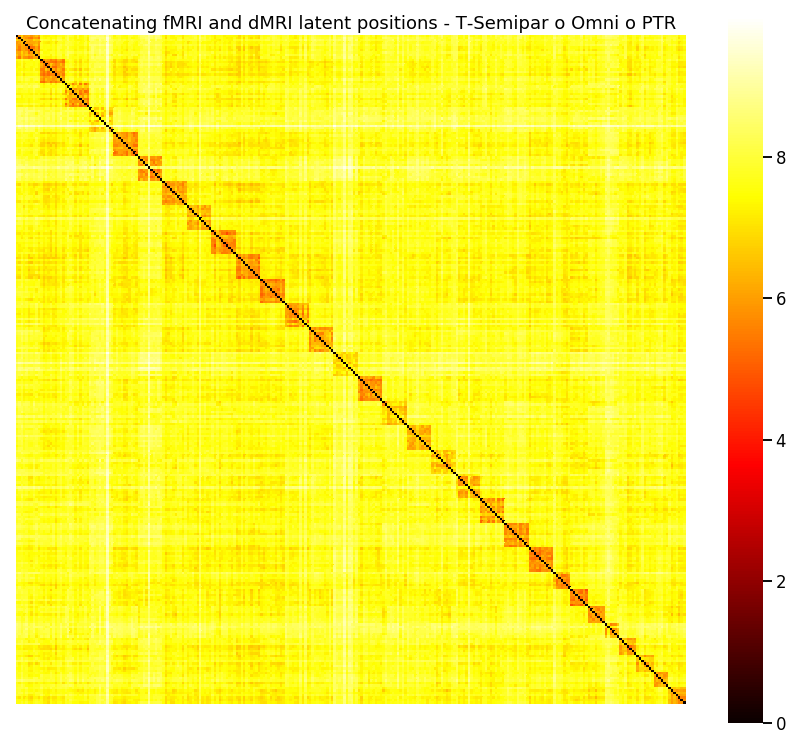

In [30]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 13))
    plot = sns.heatmap(dissimilarity, cmap='hot', square=True, xticklabels=False, yticklabels=False)
    plot.set_title("Concatenating fMRI and dMRI latent positions - T-Semipar o Omni o PTR")

In [31]:
cmds = ClassicalMDS(n_components=25)
X = cmds.fit_transform(dissimilarity)
X = np.fliplr(X)

### cMDS o T-Semipar o Omni o PTR

<Figure size 1080x1080 with 0 Axes>

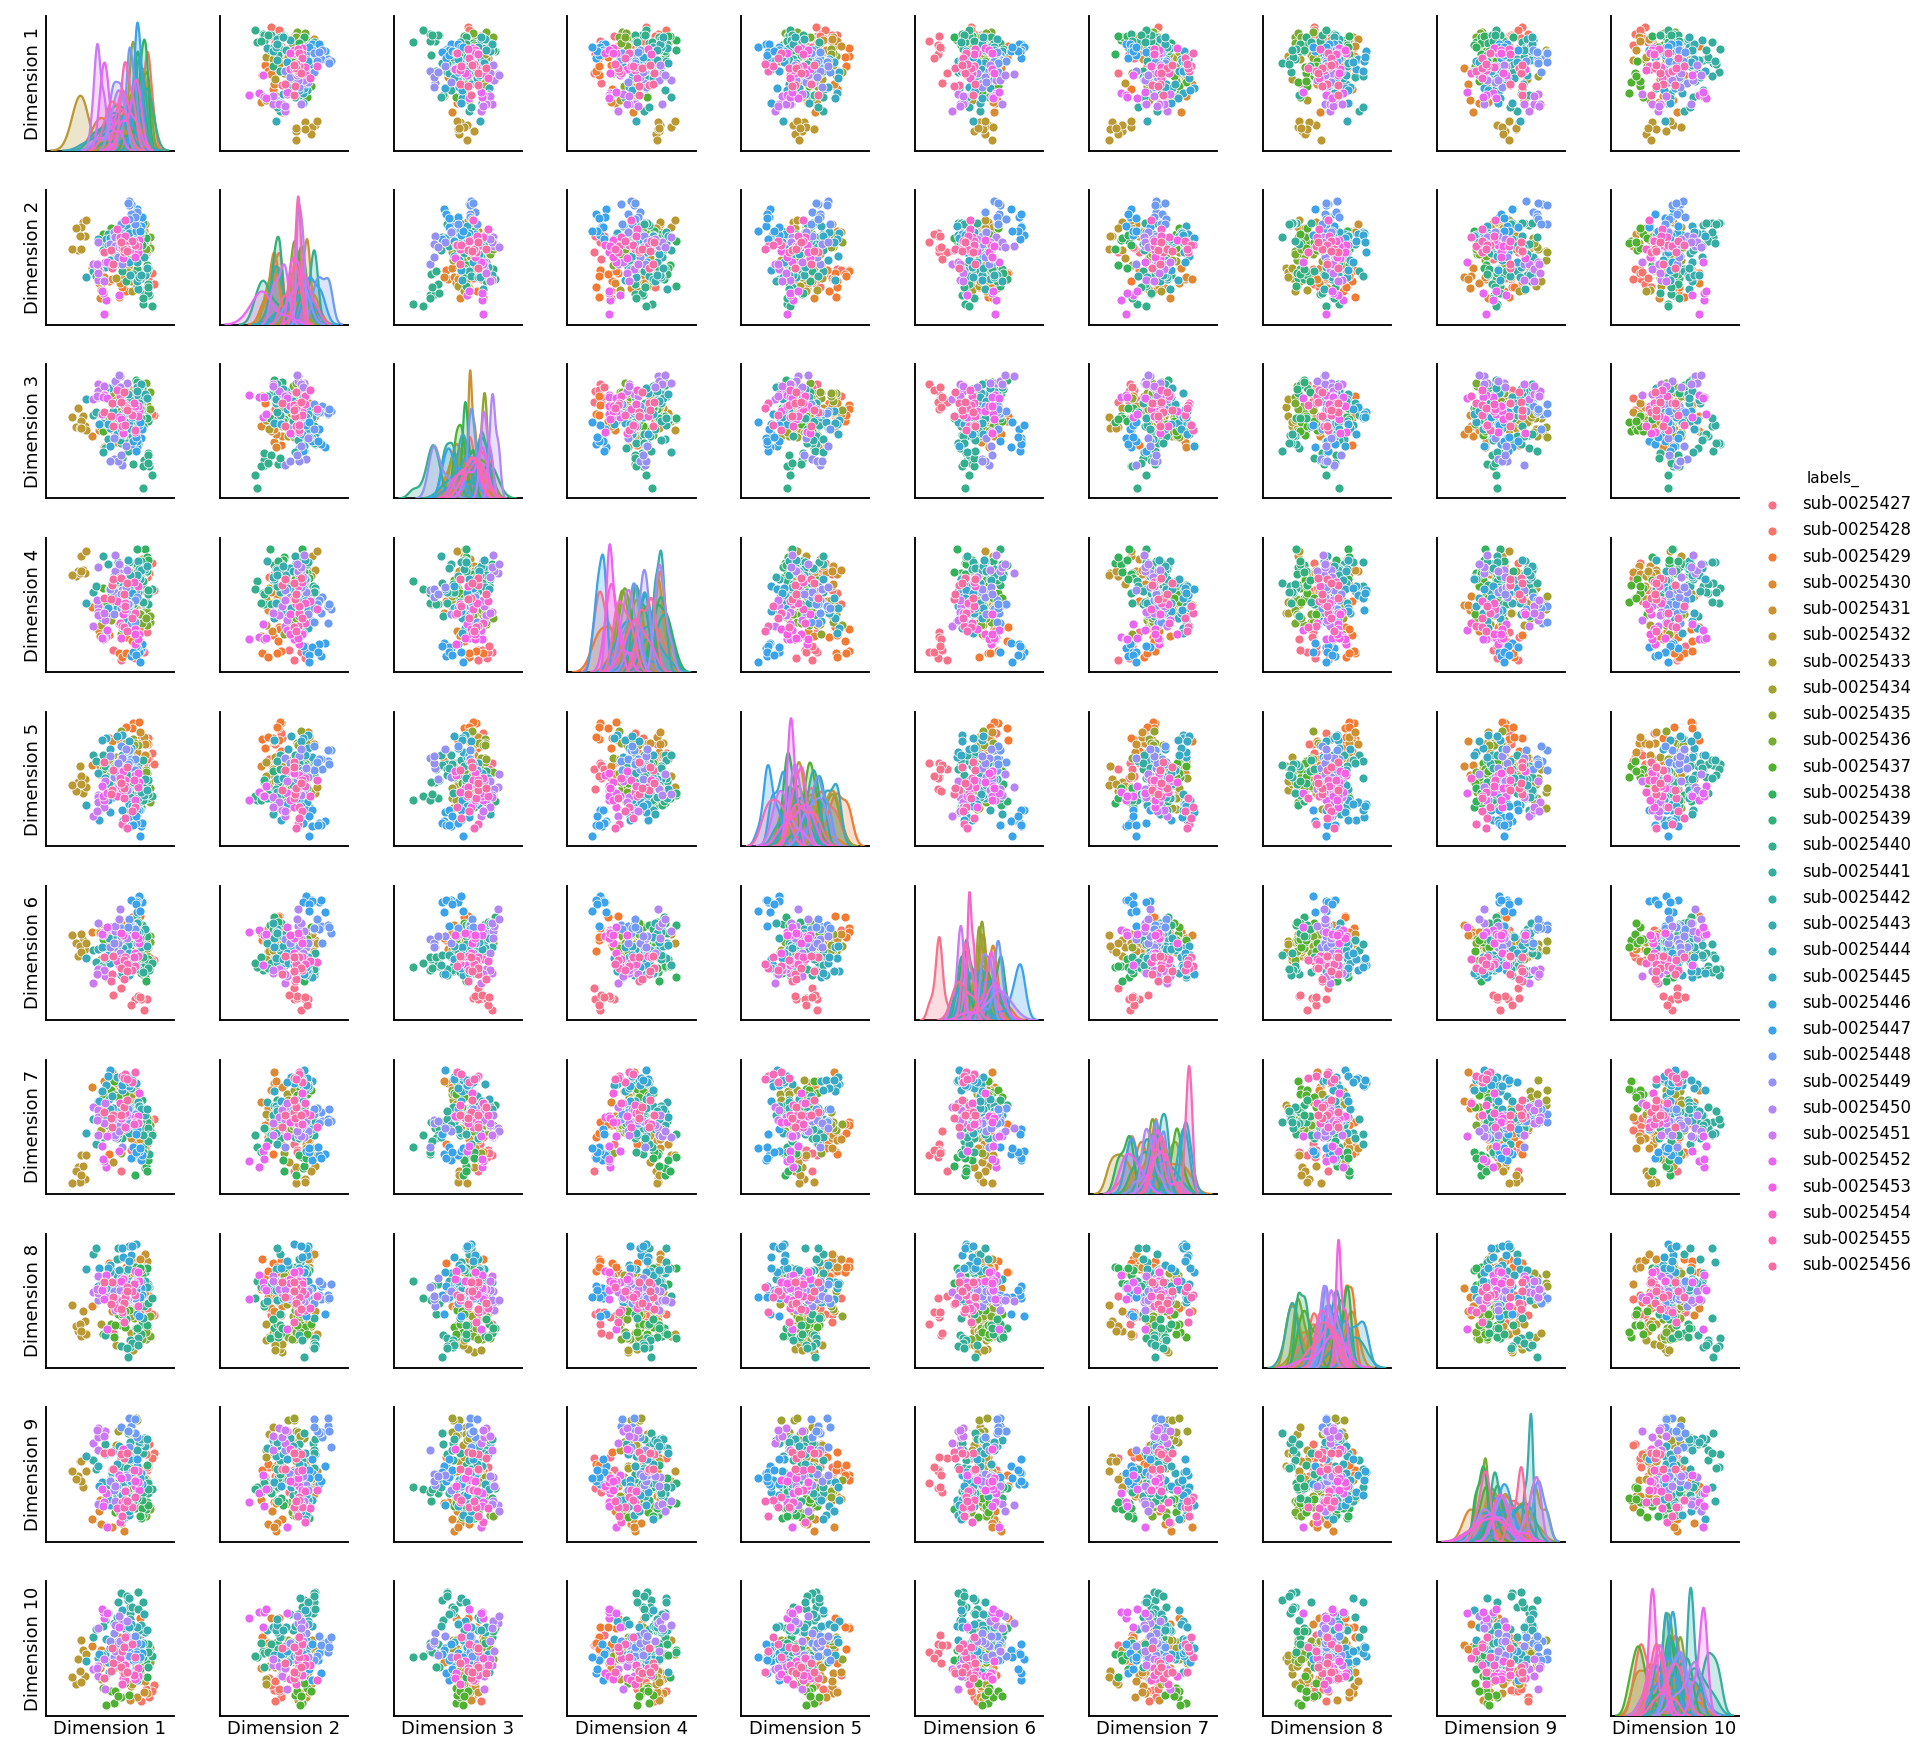

In [33]:
#df_labels = pd.DataFrame(y, columns=['labels'])
df_labels_ = pd.DataFrame(subject_labels, columns=['labels_'])
col_names =  ['Dimension {}'.format(i) for i in range(1, X.shape[1] + 1)]
df = pd.DataFrame(X, columns = col_names)
df = pd.concat([df_labels_, df], axis = 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 15))
    pairs = sns.pairplot(df, hue = 'labels_', vars=col_names[:10])
    pairs.set(xticklabels=[], yticklabels=[], yticks=[], xticks=[])

### ARI peaks at 0.985 when num_clusters = 31, but BIC is minimum when num_clusters=26

There are 30 unique labels, each corresponding to each subject.

0.985486699985732 31


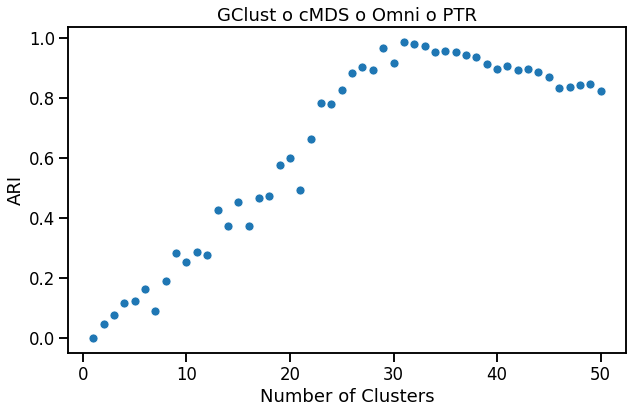

In [34]:
gclust = GaussianCluster(max_components = 50)
gclust.fit(X, subject_labels)

aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o PTR')

6677.722552127903 26


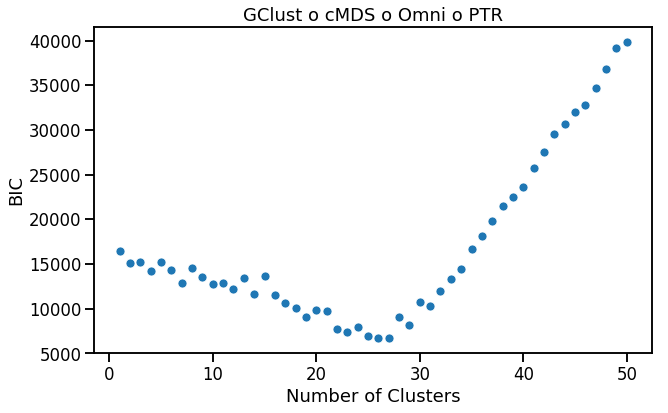

In [35]:
bics = gclust.bic_
print(np.min(bics), np.argmin(bics) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(bics) + 1), bics)
    plot.set(xlabel='Number of Clusters', ylabel='BIC', title='GClust o cMDS o Omni o PTR')